# Hands-on lattice calculations for the AUTH 2024 Accelerator Phyiscs course
*T. Prebibaj, F. Asvesta, Y. Papaphilippou*

---

# Part V: Tracking with Xsuite

Tracking in a real accelerator lattice with the tracking code [Xsuite](https://xsuite.readthedocs.io/en/latest/).

---

In [1]:
# Import xsuite modules and other libraries
import xtrack as xt
import xpart as xp
import xplt

from cpymad.madx import Madx
import numpy as np
import matplotlib.pyplot as plt

/home/tprebiba/python_environments/base-2022/miniconda/lib/python3.9/site-packages/xtrack/progress_indicator.py:95: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## The CERN Proton Synchrotron Booster (PSB)

<p align="center">
<img src=./images_lectures/psb.png width="40%">
</p>

- PSB consists of 4 identical, vertically stacked rings with commin injection and extraction lines. 

- It accelerates protons from $160$ MeV to $2$ GeV in $1.2$ seconds for high-intensity and high-brightness physics. 

- Beam intensities rage from $10^{10}$ to $10^{13}$ protons per ring and the beam emittances from $1$ mm mrad to $15$ mm mrad.

### Exercise 19 (guided): load and plot the layout of the PSB

Load the PSB line to Xsuite from the MAD-X sequence and plot it using xplt.

In [16]:
# The MAD-X sequence is at the psb/psb.seq file. The aperture of each element is defined at psb/psb_aperture.dbx
mad = Madx()
mad.options.echo = False # to not print the stdout of MAD-X  
mad.chdir('psb')
mad.call('psb_flat_bottom.madx') # loads the PSB sequence, aperture, etc. in MAD-X
line= xt.Line.from_madx_sequence(mad.sequence['psb1'],
                                 deferred_expressions=True,
                                 allow_thick=True)


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2024.04.30 10:25:30      +
  ++++++++++++++++++++++++++++++++++++++++++++
++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
++++++ info: seqedit - number of elements installed:  1
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


Converting sequence "psb1":   0%|          | 0/530 [00:00<?, ?it/s]

In [17]:
# Check elements
line_table = line.get_table()
line_table_df = line_table.to_pandas()
line_table_df[0:20]

,s,element_type,name,isthick,compound_name
0,0.000000,Marker,psb1$start,False,
1,0.000000,Marker,p01ring1$start,False,
2,0.000000,Drift,drift_0,True,
3,0.179500,Marker,bi1.bsw1l1.1_entry,False,bi1.bsw1l1.1
4,0.179500,DipoleEdge,bi1.bsw1l1.1_den,False,bi1.bsw1l1.1
5,0.179500,Bend,bi1.bsw1l1.1,True,bi1.bsw1l1.1
6,0.492500,DipoleEdge,bi1.bsw1l1.1_dex,False,bi1.bsw1l1.1
7,0.492500,Marker,bi1.bsw1l1.1_exit,False,bi1.bsw1l1.1
8,0.492500,Drift,drift_1,True,
9,0.869500,Marker,bi1.bsw1l1.2_entry,False,bi1.bsw1l1.2


In [18]:
# Get circumference
print('PSB circumference in meters: ', line.get_length()) 

PSB circumference in meters:  157.07999999999979


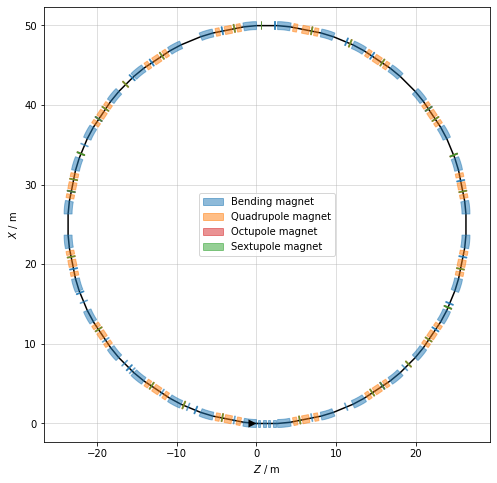

In [19]:
plot = xplt.FloorPlot(line=line, labels="S.Q.", figsize=(8,8))
plot.legend()

- The PSB ring consists of 16 identical cells with a total circumference of $157.08$ meters (relatively similar with the cases we have seen so far).

- Each cell (or period or sector) consists of one defocusing and two focusing quadrupoles, two dipoles and many higher order magnets (sextupoles, octupoles, etc). 

### Exercise 20 (guided): optics functions of PSB

Use the line.twiss() method of Xsuite to compute the optics functions around the PSB and plot them.

In [20]:
# We need to add a reference particle for the twiss calculation (mass, energy)
line.particle_ref=xp.Particles(mass0=xp.PROTON_MASS_EV,gamma0=mad.sequence.psb1.beam.gamma)
print('Reference particle added at gamma0=%s.'%(mad.sequence.psb1.beam.gamma))

line.twiss_default['method'] = '4d' # to ignore the longitudinal plane
twiss = line.twiss()
twiss_df = twiss.to_pandas()

Reference particle added at gamma0=1.1705262269290748.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [21]:
# This is the twiss table
twiss_df[0:20]

,name,s,x,px,y,py,zeta,delta,ptau,W_matrix,...,nuzeta,dzeta,dmux,dmuy,bx_chrom,by_chrom,ax_chrom,ay_chrom,wx_chrom,wy_chrom
0,psb1$start,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[2.3733288191583974, 2.906489541706499e-16, 0...",...,1.0,0.000000,0.000000,0.000000,-0.042769,1.333568,-0.261538,-1.484729,0.265012,1.995702
1,p01ring1$start,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[2.3733288191583974, 2.906489541706499e-16, 0...",...,1.0,0.000000,0.000000,0.000000,-0.042769,1.333568,-0.261538,-1.484729,0.265012,1.995702
2,drift_0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[2.3733288191583974, 2.906489541706499e-16, 0...",...,1.0,0.000000,0.000000,0.000000,-0.042769,1.333568,-0.261538,-1.484729,0.265012,1.995702
3,bi1.bsw1l1.1_entry,0.179500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[2.355583010631271, 4.996003610813204e-16, -0...",...,1.0,0.131009,-0.004973,-0.016238,-0.011867,1.480066,-0.232915,-1.327437,0.233217,1.988136
4,bi1.bsw1l1.1_den,0.179500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[2.355583010631271, 4.996003610813204e-16, -0...",...,1.0,0.131009,-0.004973,-0.016238,-0.011867,1.480066,-0.232915,-1.327437,0.233217,1.988136
5,bi1.bsw1l1.1,0.179500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[2.355583010631271, 4.996003610813204e-16, -0...",...,1.0,0.131009,-0.004973,-0.016238,-0.011867,1.480066,-0.232915,-1.327437,0.233217,1.988136
6,bi1.bsw1l1.1_dex,0.492500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[2.3305637829201467, 3.885780586188048e-16, -...",...,1.0,0.359455,-0.014158,-0.047796,0.032908,1.698713,-0.176560,-1.012402,0.179600,1.977519
7,bi1.bsw1l1.1_exit,0.492500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[2.3305637829201467, 3.885780586188048e-16, -...",...,1.0,0.359455,-0.014158,-0.047796,0.032908,1.698713,-0.176560,-1.012402,0.179600,1.977519
8,drift_1,0.492500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[2.3305637829201467, 3.885780586188048e-16, -...",...,1.0,0.359455,-0.014158,-0.047796,0.032908,1.698713,-0.176560,-1.012402,0.179600,1.977519
9,bi1.bsw1l1.2_entry,0.869500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[2.3107131303531805, 4.440892098500626e-16, -...",...,1.0,0.634611,-0.025899,-0.090321,0.069478,1.882949,-0.100155,-0.576220,0.121895,1.969143


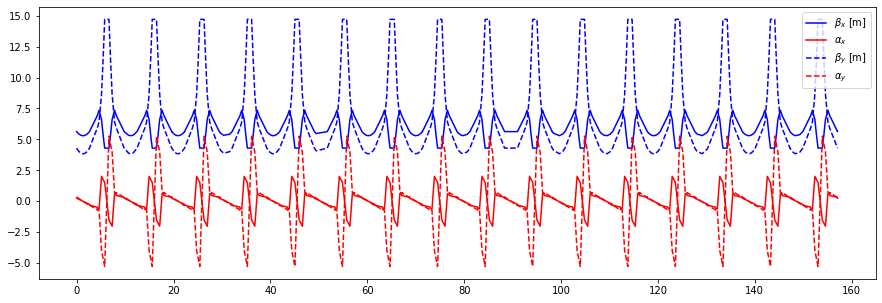

In [22]:
plt.figure(figsize=(15,5))
plt.plot(twiss_df['s'], twiss_df['betx'], label=r'$\beta_x$ [m]', c='blue')
plt.plot(twiss_df['s'], twiss_df['alfx'], label=r'$\alpha_x$', c='red')
plt.plot(twiss_df['s'], twiss_df['bety'], label=r'$\beta_y$ [m]', c='blue', ls='--')
plt.plot(twiss_df['s'], twiss_df['alfy'], label=r'$\alpha_y$', c='red', ls='--')
plt.legend()


### Exercise 21 (guided): matching the tunes

In PSB, all the focusing quadrupoles are powered in series which means all of them can have the same strength. Same applies for the defocusing quadrupoles. The strength of the focusing quadrupoles is conventionally named as "kbrqf" while for the defocusing "kbrqd". 

Xsuite has algorithms to calculate the quadrupole strengths in order to achieve our desired optics constrains (for example a certain tune, an upper limit for the beta-function etc.). This process is known as optics matching. 

In this exercise, vary the quadrupole strength to match the transverse betatron tunes to $(Q_x,Q_y)=(4.17,4.23)$ using the `line.match` command of Xsuite. 

In [23]:
# The initial lattice gives the following tunes
print('Qx = ', twiss.qx)
print('Qy = ', twiss.qy)

Qx =  4.399999999756882
Qy =  4.450000000567766


In [24]:
# Here we vary the strength of the quadrupoles (two knobs) to reach the target tunes (two constraints)
# The matching process is not always possible..
line.match(
      vary=[
            xt.Vary('kbrqf', step=1e-8),
            xt.Vary('kbrqd', step=1e-8),
      ],
      targets = [
                  xt.Target('qx', 4.17, tol=1e-5),
                  xt.Target('qy', 4.23, tol=1e-5)
      ]
)

Matching: model call n. 8       



In [25]:
# We re-twiss the latice
twiss_after = line.twiss()
twiss_after_df = twiss_after.to_pandas()
print('Horizontal tune after the matching Qx = ', twiss_after.qx)
print('Vertical tune after the matching Qy = ', twiss_after.qy)

Horizontal tune after the matching Qx =  4.170001792569275
Vertical tune after the matching Qy =  4.230003706158103


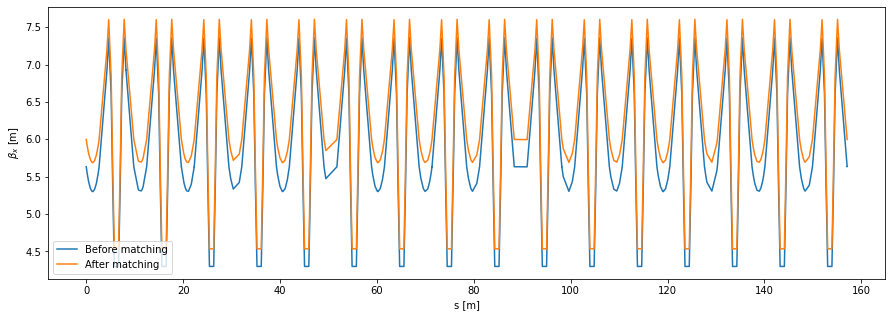

In [26]:
# The beta-function changed in the new configuration of the quadrupoles
plt.figure(figsize=(15,5))
plt.plot(twiss_df['s'], twiss_df['betx'], label='Before matching')
plt.plot(twiss_after_df['s'], twiss_after_df['betx'], label='After matching')
plt.xlabel('s [m]')
plt.ylabel(r'$\beta_x$ [m]')
plt.legend()

### Exercise 22 (guided): tracking in the PSB

- Generate a matched Guassian distribution of $1000$ particles and track it for one turn in the PSB lattice. Plot the particle trajectories along the ring in the vertical plane (y). 

- Track the same distribution for $1000$ turns (without saving the particle state at all PSB elements). How long did it take?


In [27]:
# Xsuite tracks in 3D, so we need to add a voltage to the RF cavity to simulate the longitudinal motion
line.element_refs['br.c02'].voltage = 0.008*1e6
print('Constant voltage = 8 kV added to the dummy RF.')

particles = xp.generate_matched_gaussian_bunch(num_particles=1000,
                                total_intensity_particles=1e10,
                                nemitt_x=1e-6, nemitt_y=1e-6, sigma_z=10,
                                particle_ref=line.particle_ref,
                                line=line
                                )

Constant voltage = 8 kV added to the dummy RF.
*** Maximum RMS bunch length 24.692096598476212m.


/home/tprebiba/python_environments/base-2022/miniconda/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


... distance to target bunch length: -9.8998e+00
... distance to target bunch length: 1.4070e+01
... distance to target bunch length: 1.0223e+01
... distance to target bunch length: 6.1652e-01
... distance to target bunch length: -6.3193e-02
... distance to target bunch length: -5.7318e-04
... distance to target bunch length: 8.3483e-09
... distance to target bunch length: -5.5011e-05
--> Bunch length: 10.00000000834825
--> Emittance: 0.23228237555785303


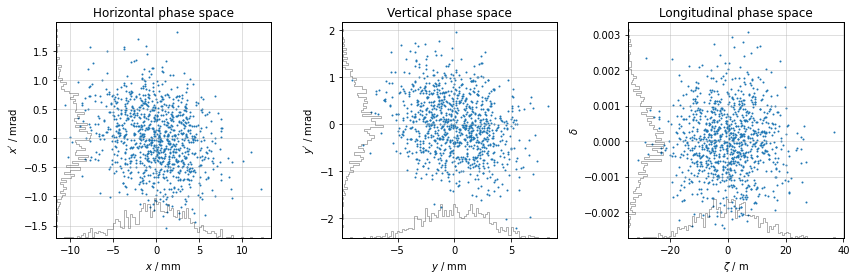

In [28]:
plot = xplt.PhaseSpacePlot(particles)
plot.fig.tight_layout()

In [29]:
# Tracking for one turn but saving the particle distribution at all PSB elements
line.track(particles, num_turns=1, turn_by_turn_monitor='ONE_TURN_EBE') # to save in all elements

Text(0, 0.5, 'y [mm]')

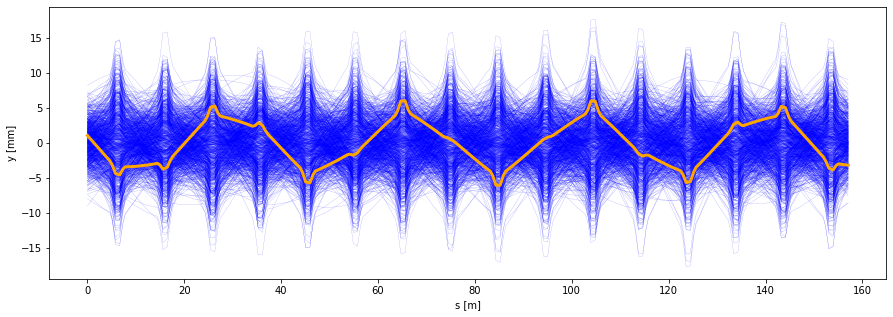

In [30]:
# Plotting the particle trajectories in y
plt.figure(figsize=(15,5))
for i in range(1000):
    plt.plot(line.record_last_track.s[0], line.record_last_track.y[i]*1e3, '-', lw=0.1, c='blue')
plt.plot(line.record_last_track.s[0], line.record_last_track.y[0]*1e3, '-', lw=3, c='orange', label='Single particle trajectory')
plt.xlabel('s [m]')
plt.ylabel('y [mm]')

> Note: the particle motion in a real accelerator is not that far from the one we saw in Exercise 15.

In [32]:
import time
start = time.time()
line.track(particles, num_turns=1000)
end = time.time()
print('Tracking time for 1000 turns = ', end-start, ' seconds')
print('Tracking time per turn per particle = ', (end-start)/(1000*1000)*1e6, 'microseconds')

Tracking time for 1000 turns =  9.336814641952515  seconds
Tracking time per turn per particle =  9.336814641952515 microseconds
